In [1]:
%reload_ext autoreload
%autoreload 2

Mounted at /content/drive


/content/drive/MyDrive/dip-spectral-master


In [3]:
!pip install scikit-image==0.16.2
import matplotlib.pyplot as plt
import numpy as np
import numpy.fft as fft
import torch
import torch.nn as nn
import torch.fft as fft_torch
from util.common_utils import *

import os
import torch.nn.functional as F
from module.skip import skip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.5 MB 303 kB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3


In [4]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def make_data_list(file_path,file_array):
    file_data = []
    for i in range(len(file_array)):
        data_file = file_array[i]
        data_from_file = np.load(os.path.join(file_path,data_file),'r')
        file_data.append(data_from_file)
    return file_data

In [7]:
def get_circular_statistic(img_it,img_gt,size=0.2):
  if len(img_it.shape)==3:
    img_it = rgb2gray(img_it)
  
  if len(img_gt.shape)==3:
    img_gt = rgb2gray(img_gt)
  
  assert(size>0 and size<1)
  ftimage_it = np.fft.fft2(img_it)
  ftimage_it = abs(np.fft.fftshift(ftimage_it))

  ftimage_gt = np.fft.fft2(img_gt)
  ftimage_gt = abs(np.fft.fftshift(ftimage_gt))

  m_data = ftimage_it/(ftimage_gt+1e-8)
  m_data = np.clip(m_data,0,1)
  h,w = m_data.shape
  center = (int(w/2),int(h/2))
  Y, X = np.ogrid[:h,:w]
  dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

  avg_mask_list = []
  pre_mask = np.zeros((h,w))
  for sz in np.linspace(size,1,int(1/size)):
    radius = center[0]*sz
    mask =dist_from_center <= radius
    mask = mask.astype(np.int32)

    mask_sz = (mask-pre_mask).astype(np.int32)
    pre_mask = mask
    avg_mask_list.append(np.sum(mask_sz*m_data)/np.sum(mask_sz))
  return avg_mask_list

In [8]:
#### function for creating Gaussian Pyramid
def gaussian_kernel(size=5, device=torch.device('cpu'), channels=3, sigma=3, dtype=torch.float):
    # Create Gaussian Kernel. In Numpy
    interval  = (2*sigma +1)/(size)
    ax = np.linspace(-(size - 1)/ 2., (size-1)/2., size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx)+ np.square(yy)) / np.square(sigma))
    kernel /= np.sum(kernel)
    # Change kernel to PyTorch. reshapes to (channels, 1, size, size)
    kernel_tensor = torch.as_tensor(kernel, dtype=dtype)
    kernel_tensor = kernel_tensor.repeat(channels, 1 , 1, 1)
    kernel_tensor.to(device)
    return kernel_tensor

def gaussian_conv2d(x, g_kernel, dtype=torch.float):
    #Assumes input of x is of shape: (minibatch, depth, height, width)
    #Infer depth automatically based on the shape
    channels = g_kernel.shape[0]
    padding = g_kernel.shape[-1] // 2 # Kernel size needs to be odd number
    if len(x.shape) != 4:
        raise IndexError('Expected input tensor to be of shape: (batch, depth, height, width) but got: ' + str(x.shape))
    y = F.conv2d(x, weight=g_kernel, stride=1, padding=padding, groups=channels)
    return y

def downsample(x):
    # Downsamples along  image (H,W). Takes every 2 pixels. output (H, W) = input (H/2, W/2)
    return x[:, :, ::2, ::2]

def create_laplacian_pyramid(x, kernel, levels):
    upsample = torch.nn.Upsample(scale_factor=2) # Default mode is nearest: [[1 2],[3 4]] -> [[1 1 2 2],[3 3 4 4]]
    pyramids = []
    current_x = x
    for level in range(0, levels):
        gauss_filtered_x = gaussian_conv2d(current_x, kernel)
        down = downsample(gauss_filtered_x)
        # Original Algorithm does indeed: L_i  = G_i  - expand(G_i+1), with L_i as current laplacian layer, and G_i as current gaussian filtered image, and G_i+1 the next.
        # Some implementations skip expand(G_i+1) and use gaussian_conv(G_i). We decided to use expand, as is the original algorithm
        laplacian = current_x - upsample(down)
        pyramids.append(laplacian)
        current_x = down
    pyramids.append(current_x)
    return pyramids

In [9]:
guide_num = 3
train_name = '/content/drive/MyDrive/dip-spectral-master/mri data/GT_NEIGH_DIP2'
train_array = os.listdir(train_name)
train_array = sorted(train_array)
Neighbor = make_data_list(train_name,train_array)[0:guide_num]

test_gt = '/content/drive/MyDrive/dip-spectral-master/mri data/GT_TEST_DIP2'
test_gt_array = os.listdir(test_gt)
test_gt_array = sorted(test_gt_array)
test_groundtruth = make_data_list(test_gt,test_gt_array)[0]
test_groundtruth = np.abs(test_groundtruth)/np.max(np.abs(test_groundtruth))
## Noisy reference image to be denoised 
test_name = '/content/drive/MyDrive/dip-spectral-master/mri data/NOISE_image_DIP2' # input image actually the name will change later
test_array = os.listdir(test_name)
test_array = sorted(test_array)
y_input  = make_data_list(test_name,test_array)[0]
y_input_torch = torch.from_numpy(y_input).type(dtype)
y_input_torch = torch.abs(y_input_torch)/torch.max(torch.abs(y_input_torch))
y_input_torch = torch.abs(y_input_torch.unsqueeze(0)).to(device)

gakernel = gaussian_kernel(size=5, channels=1, sigma=5, dtype=torch.float).to(device)
y_input_Lap = create_laplacian_pyramid(y_input_torch.unsqueeze(0),gakernel,1)[0]

Neighbor_list = []
for img in Neighbor:
  img_torch = torch.from_numpy(abs(img)).unsqueeze(0).unsqueeze(0).to(device)
  img_torch_Lap = create_laplacian_pyramid(img_torch,gakernel,1)[0]
  Neighbor_list.append(img_torch_Lap)


## Visualization
# plt.imshow(abs(y_input),'gray')
# plt.figure()
# plt.imshow(abs(test_groundtruth),'gray')
# plt.figure()
# plt.imshow(abs(Neighbor[1]),'gray')

## Calculate PSNR
#print(compare_psnr(abs(y_input),abs(test_groundtruth)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)


#### Baseline DIP

In [51]:
#input type
INPUT = 'noise' # 'meshgrid', 'noise', 'fourier'
var=1
input_depth = 3 #32
output_depth = 1 #for MRI image
#net_input = get_noise(input_depth, INPUT, (y_input_torch.shape[1]//32, y_input_torch.shape[2]//32),var=var).type(dtype).detach()
net_input = get_noise(input_depth, INPUT, (y_input_torch.shape[1], y_input_torch.shape[2])).type(dtype).detach()
pad = 'reflection'

#optimization parameters
OPTIMIZER = 'adam'
num_iter = 5000
LR = 1e-2
reg_noise_std = 0#1./30, injecting noise in the input.
show_every = 100


# Loss
mse = torch.nn.MSELoss().type(dtype)
img_noisy_torch = y_input_torch.unsqueeze(0)

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
last_net = None
psrn_noisy_last = 0

i = 0
best_psnr = 0
PSNR =[]
fbc_dir_clean = []
fbc_dir_noisy = []
loss_x_dir = []
loss_z_dir = []
loss_data_dir = []
#log_path = '/content/drive/MyDrive/dip-spectral-master/experiment results/guided mri/baseline/'
log_path = '/content/drive/MyDrive/dip-spectral-master/experiment results/guided mri/U-Net baseline/'
#net = decoder(num_input_channels=input_depth, num_output_channels=output_depth).type(dtype)
net = skip(
    input_depth, output_depth, 
                num_channels_down = [8, 16, 32, 64, 128], 
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4], 
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
def closure():
    
    global i, out, psrn_noisy_last, last_net, net_input, best_img, best_psnr 

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = net(net_input)
    
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()

    #print(np.max(img_noisy_torch.detach().cpu().numpy()[0]),np.min(img_noisy_torch.detach().cpu().numpy()[0]))
    #print(np.max(out.detach().cpu().numpy()[0]),np.min(out.detach().cpu().numpy()[0]))

    #print(test_groundtruth.shape)
    #print(out.detach().cpu().numpy().shape)

    psrn_noisy = compare_psnr(img_noisy_torch.detach().cpu().numpy()[0], out.detach().cpu().numpy()[0])
    psrn_gt    = compare_psnr(np.abs(test_groundtruth), out.detach().cpu().numpy()[0][0])
    PSNR.append(psrn_gt)
   
      

    loss_data_dir.append(total_loss.item())
    
    pre_img = out.detach().cpu().numpy()[0]
    pre_img = pre_img.transpose(1, 2, 0)[:,:,0]
    if psrn_noisy > best_psnr:
      best_img = pre_img
      best_psnr = psrn_noisy
    fbc_dir_noisy.append(get_circular_statistic(pre_img,abs(y_input)))
    fbc_dir_clean.append(get_circular_statistic(pre_img,abs(test_groundtruth)))
    
    print ('Iteration: %05d, Loss: %f, PSRN_gt: %f' % (i, total_loss.item(), psrn_gt))
    #log_file.write('Iteration: %05d, Loss: %f, PSRN_gt: %f, mask: %s, ratio: %f\n' % (i, total_loss.item(), psrn_gt, avg_mask_it, ratio_it))
    #log_file.flush()

    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5:
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
        np.save(log_path+'PSNR',PSNR)
        np.save(log_path+'fbc_clean',fbc_dir_clean)
        np.save(log_path+'fbc_noisy',fbc_dir_noisy)
        np.save(log_path+'best_img', best_img)
    if i % show_every == 0:
      plt.figure()
      plt.plot(fbc_dir_noisy)
      plt.show()
      plt.imshow(pre_img,'gray')
      plt.show()

    i += 1

    return total_loss,PSNR,fbc_dir_clean,fbc_dir_noisy,best_img

print('Starting optimization with ADAM')
#optimizer = torch.optim.Adam(net.parameters(), lr=LR,eps=1e-2)
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
for j in range(num_iter):
    optimizer.zero_grad()
    closure()
    optimizer.step()

Output hidden; open in https://colab.research.google.com to view.

best psnr 26.034567541653164


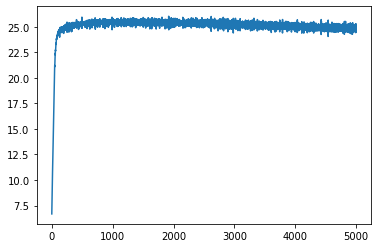

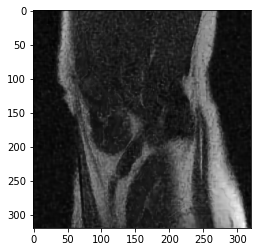

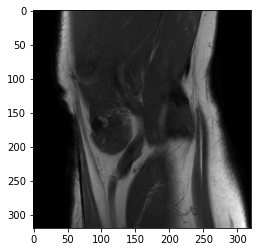

In [17]:
psnr = np.load('/content/drive/MyDrive/dip-spectral-master/experiment results/guided mri/U-Net/U-Net baselinePSNR.npy')
plt.plot(psnr)
plt.figure()
best_img = np.load('/content/drive/MyDrive/dip-spectral-master/experiment results/guided mri/U-Net/U-Net baselinebest_img.npy')
plt.imshow(best_img,'gray')
print('best psnr',max(psnr))
plt.figure()
plt.imshow(test_groundtruth,'gray')

#### Guided DIP

In [23]:
#input type
INPUT = 'noise' # 'meshgrid', 'noise', 'fourier'
var=1
input_depth = 3 #32
output_depth = 1 #for MRI image
#net_input = get_noise(input_depth, INPUT, (y_input_torch.shape[1]//32, y_input_torch.shape[2]//32),var=var).type(dtype).detach()
net_input = get_noise(input_depth, INPUT, (y_input_torch.shape[1], y_input_torch.shape[2])).type(dtype).detach()
pad = 'reflection'
#print(net_input.shape)
z_list =[] 
for j in range(guide_num):
    #z_random = get_noise(input_depth, INPUT, (y_input_torch.shape[1]//32, y_input_torch.shape[2]//32),var=var).type(dtype).detach().requires_grad_(True)
    z_random = get_noise(input_depth, INPUT, (y_input_torch.shape[1], y_input_torch.shape[2])).type(dtype).detach()
    z_list.append(z_random)



#optimization parameters
OPTIMIZER = 'adam'
num_iter = 5000
LR = 1e-2
reg_noise_std = 0#1./30, injecting noise in the input.
show_every = 100


# Loss
mse = torch.nn.MSELoss().type(dtype)
#img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)
img_noisy_torch = y_input_torch.unsqueeze(0)

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
last_net = None
psrn_noisy_last = 0

i = 0
best_psnr = 0
PSNR =[]
fbc_dir_clean = []
fbc_dir_noisy = []
loss_x_dir = []
loss_z_dir = []
loss_data_dir = []
log_path = '/content/drive/MyDrive/dip-spectral-master/experiment results/guided mri/U-Net/guided/'

net = skip(
    input_depth, output_depth, 
                num_channels_down = [8, 16, 32, 64, 128], 
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4], 
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

def closure():
    
    global i, out, psrn_noisy_last, last_net, net_input, best_img, best_psnr

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = net(net_input)
    loss_x = torch.tensor(0).float().to(device)
    loss_z = torch.tensor(0).float().to(device)
    for z_i,image in zip(z_list,Neighbor_list):
        z_i = z_i.to(device)
        z_i_out = net(z_i)
        z_i_out = z_i_out.to(device)
        z_i_Lap = create_laplacian_pyramid(z_i_out,gakernel,1)[0]
        loss_x += mse(z_i_Lap.type(dtype),torch.abs(image))# second term of the equation ||x_c-G(z_i)||
        loss_z += mse(z_i ,net_input)  # which is the third term of the equation || z_i -z||
    loss1 = mse(out, img_noisy_torch)
    loss2 = loss_x
    loss3 = loss_z*1e-2
    total_loss = loss1+loss2+loss3
    total_loss.backward()

    psrn_noisy = compare_psnr(img_noisy_torch.detach().cpu().numpy()[0], out.detach().cpu().numpy()[0])
    psrn_gt    = compare_psnr(np.abs(test_groundtruth), out.detach().cpu().numpy()[0])
    PSNR.append(psrn_gt)
    loss_x_dir.append(loss2.item())
    loss_z_dir.append(loss3.item())
    loss_data_dir.append(loss1.item())
    
    pre_img = out.detach().cpu().numpy()[0]
    pre_img = pre_img.transpose(1, 2, 0)[:,:,0]
    if psrn_noisy > best_psnr:
      best_img = pre_img
      best_psnr = psrn_noisy
    fbc_dir_noisy.append(get_circular_statistic(pre_img,abs(y_input)))
    fbc_dir_clean.append(get_circular_statistic(pre_img,abs(test_groundtruth)))
    
    print ('Iteration: %05d, Loss: %f, PSRN_gt: %f' % (i, total_loss.item(), psrn_gt))
    #log_file.write('Iteration: %05d, Loss: %f, PSRN_gt: %f, mask: %s, ratio: %f\n' % (i, total_loss.item(), psrn_gt, avg_mask_it, ratio_it))
    #log_file.flush()

    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5:
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
        np.save(log_path+'PSNR',PSNR)
        np.save(log_path+'fbc_clean',fbc_dir_clean)
        np.save(log_path+'fbc_noisy',fbc_dir_noisy)
        np.save(log_path+'best_img',best_img)
    
    if i % show_every == 0:
      plt.figure()
      plt.imshow(pre_img,'gray')
      plt.show()
      plt.figure()
      plt.plot(loss_x_dir)
      plt.plot(loss_z_dir)
      plt.plot(loss_data_dir)
      plt.legend(['guided loss','random seed loss','data loss'])
      
    i += 1

    return total_loss,PSNR,fbc_dir_clean,fbc_dir_noisy

print('Starting optimization with ADAM')
#optimizer = torch.optim.Adam(net.parameters(), lr=LR,eps=1e-2)
#optimizer2 = torch.optim.Adam([z_list[0],z_list[1]],lr=0,eps=1e-2)
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
optimizer2 = torch.optim.Adam([z_list[0],z_list[1]],lr=LR)
for j in range(num_iter):
    optimizer.zero_grad()
    optimizer2.zero_grad()
    closure()
    optimizer.step()
    optimizer2.step()

Output hidden; open in https://colab.research.google.com to view.

best psnr 26.372243518241383


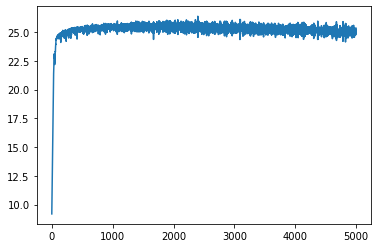

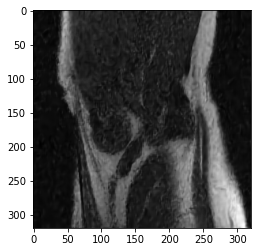

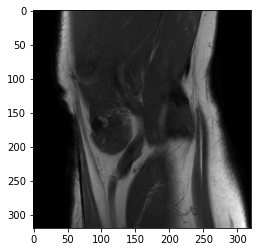

In [24]:
psnr = np.load('/content/drive/MyDrive/dip-spectral-master/experiment results/guided mri/U-Net/guided/PSNR.npy')
plt.plot(psnr)
plt.figure()
best_img = np.load('/content/drive/MyDrive/dip-spectral-master/experiment results/guided mri/U-Net/guided/best_img.npy')
plt.imshow(best_img,'gray')
print('best psnr',max(psnr))
plt.figure()
plt.imshow(test_groundtruth,'gray')

#### Visualization and Comparison

PSNR:

besr psnrs:
baseline 26.034567541653164
reg=0.001 26.284364800201253
reg=0.01 26.372243518241383
reg=0.1 26.491801324763085
reg=1 26.476303619808018


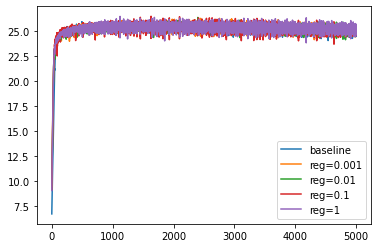

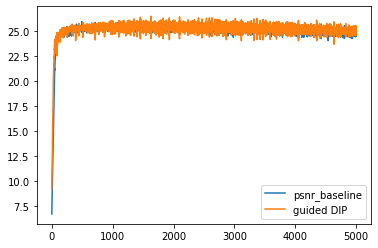

In [35]:
'''
here the reg value corresponds to the regularization strength for the loss: ||z-z_i||^2
'''
psnr_baseline = np.load('/content/drive/MyDrive/dip-spectral-master/experiment results/guided mri/U-Net/baseline/U-Net baselinePSNR.npy')
psnr_reg_1 = np.load('/content/drive/MyDrive/dip-spectral-master/experiment results/guided mri/U-Net/guided_reg=0.001/PSNR.npy')
psnr_reg_2 = np.load('/content/drive/MyDrive/dip-spectral-master/experiment results/guided mri/U-Net/guided_reg=0.01/PSNR.npy')
psnr_reg_3 = np.load('/content/drive/MyDrive/dip-spectral-master/experiment results/guided mri/U-Net/guided_reg=0.1/PSNR.npy')
psnr_reg_4 = np.load('/content/drive/MyDrive/dip-spectral-master/experiment results/guided mri/U-Net/guided_reg=1/PSNR.npy')
plt.figure()
plt.plot(psnr_baseline)
plt.plot(psnr_reg_1)
plt.plot(psnr_reg_2)
plt.plot(psnr_reg_3)
plt.plot(psnr_reg_4)
plt.legend(['baseline','reg=0.001','reg=0.01','reg=0.1','reg=1'])
print('besr psnrs:')
print('baseline',max(psnr_baseline))
print('reg=0.001',max(psnr_reg_1))
print('reg=0.01',max(psnr_reg_2))
print('reg=0.1',max(psnr_reg_3))
print('reg=1',max(psnr_reg_4))
plt.figure()
plt.plot(psnr_baseline)
plt.plot(psnr_reg_3)
plt.legend(['psnr_baseline','guided DIP'])

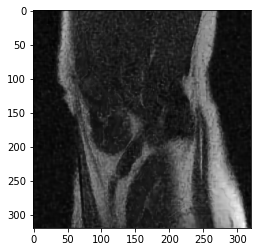

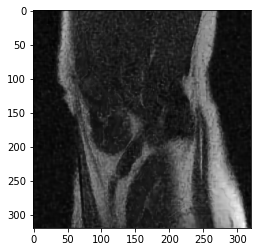

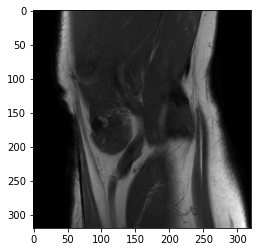

In [38]:
img_baseline = np.load('/content/drive/MyDrive/dip-spectral-master/experiment results/guided mri/U-Net/baseline/U-Net baselinebest_img.npy')
img_guided = np.load('/content/drive/MyDrive/dip-spectral-master/experiment results/guided mri/U-Net/guided_reg=0.1/best_img.npy')
plt.imshow(img_baseline,'gray')
plt.figure()
plt.imshow(img_baseline,'gray')
plt.figure()
plt.imshow(test_groundtruth,'gray')

#### Frequency reconstruction:

<Figure size 432x288 with 0 Axes>

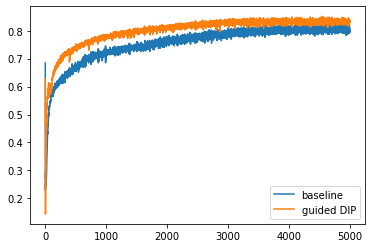

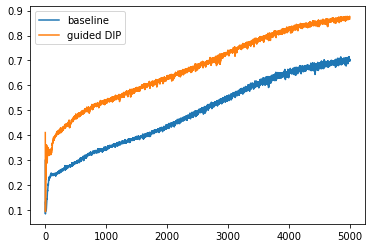

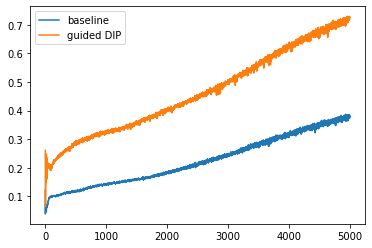

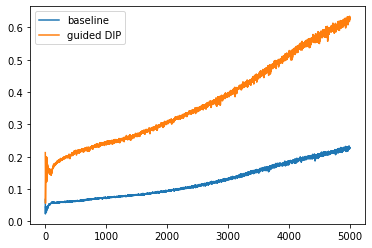

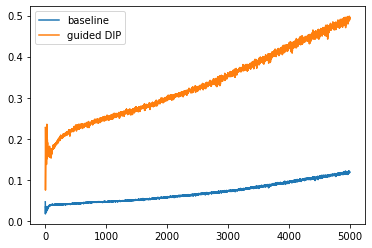

In [40]:
fbc_baseline = np.load('/content/drive/MyDrive/dip-spectral-master/experiment results/guided mri/U-Net/baseline/U-Net baselinefbc_noisy.npy')
fbc_guided = np.load('/content/drive/MyDrive/dip-spectral-master/experiment results/guided mri/U-Net/guided_reg=0.1/fbc_clean.npy')
plt.figure()
for i in range(5):
  plt.figure()
  plt.plot(fbc_baseline[:,i])
  plt.plot(fbc_guided[:,i])
  plt.legend(['baseline','guided DIP'])